In [938]:
import pandas as pd
from pathlib import Path
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt

In [939]:
data_path = Path("./data/")
data = pd.read_csv(data_path / "chess.csv", names=['id','group','pre','post', 'gender', 'age', 'math_grade', 'overall_grade'])

In [940]:
data.head()

,id,group,pre,post,gender,age,math_grade,overall_grade
0,3,Control,17,14,Girl,24,6.0,Poor
1,4,Control,16,7,Girl,19,6.5,Poor
2,5,Control,9,9,Girl,23,7.0,Poor
3,6,Control,14,11,Girl,17,6.7,Poor
4,7,Control,9,11,Boy,21,6.8,Poor


In [941]:
data_pre = data[['id','group', 'pre', 'gender', 'age', 'math_grade', 'overall_grade']].rename(columns={'pre': 'answers'})
data_pre['status'] = 0
data_post = data[['id','group', 'post', 'gender', 'age', 'math_grade', 'overall_grade']].rename(columns={'post': 'answers'})
data_post['status'] = 1

In [946]:
data_processed = data_post.drop("status", axis=1) #pd.concat([data_pre, data_post])

In [947]:
data_processed.head()

,id,group,answers,gender,age,math_grade,overall_grade
0,3,0,14,1,24,6.0,Poor
1,4,0,7,1,19,6.5,Poor
2,5,0,9,1,23,7.0,Poor
3,6,0,11,1,17,6.7,Poor
4,7,0,11,0,21,6.8,Poor


In [948]:
data_processed.loc[data_processed.group == 'Control', 'group'] = 0
data_processed.loc[data_processed.group == 'Treatment', 'group'] = 1

In [949]:
data_processed.loc[data_processed.gender == 'Boy', 'gender'] = 0
data_processed.loc[data_processed.gender == 'Girl', 'gender'] = 1

In [950]:
data_processed.loc[data_processed.overall_grade == 'Poor', 'overall_grade'] = 0
data_processed.loc[data_processed.overall_grade == 'Average', 'overall_grade'] = 1
data_processed.loc[data_processed.overall_grade == 'Excellent', 'overall_grade'] = 2

## Exploring the Data

In [951]:
profile = ProfileReport(data, title='Pandas Profiling Report', html={'style':{'full_width':True}})

In [952]:
profile.to_widgets()

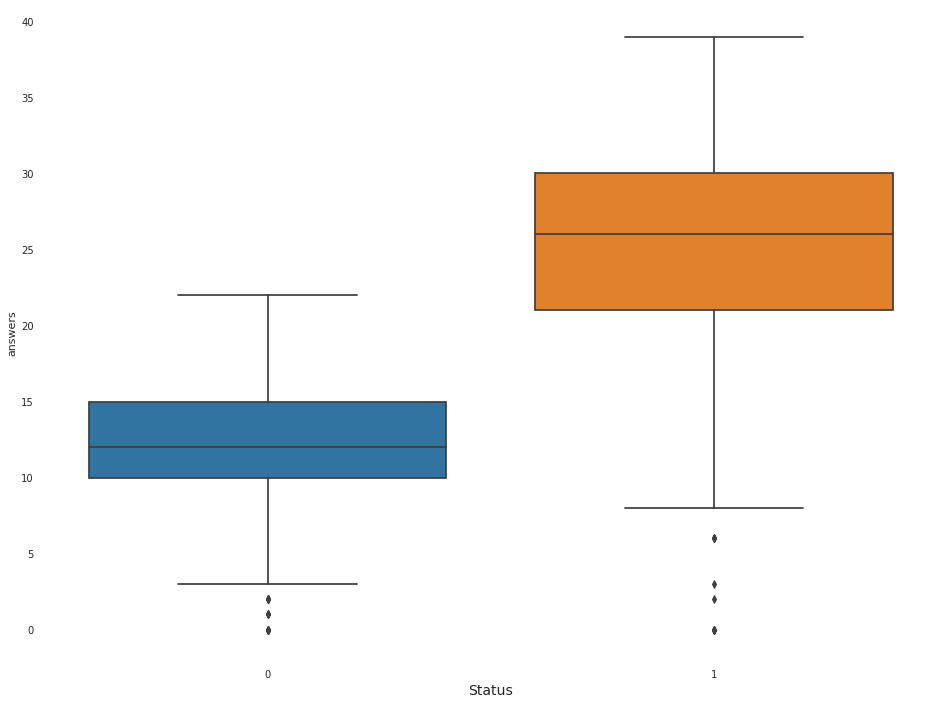

In [954]:
plt.figure(figsize=(16,12))
sns.boxplot(y='answers',x='group', data=data_processed)
plt.xlabel("Status", fontsize=14)
plt.legend(prop={'size': 14});

## Statistical estimate

In [955]:
import statsmodels.api as sm
from patsy import dmatrices

In [957]:
# data_processed['interaction'] = data_processed['status']*data_processed['group']

In [958]:
data_processed.head()

,id,group,answers,gender,age,math_grade,overall_grade
0,3,0,14,1,24,6.0,0
1,4,0,7,1,19,6.5,0
2,5,0,9,1,23,7.0,0
3,6,0,11,1,17,6.7,0
4,7,0,11,0,21,6.8,0


In [959]:
y, X = dmatrices('answers ~  group', data=data_processed, return_type='dataframe')
mod = sm.OLS(y, X) 
res = mod.fit()

In [960]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                answers   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     1192.
Date:                Wed, 29 Apr 2020   Prob (F-statistic):          4.08e-168
Time:                        03:46:19   Log-Likelihood:                -2881.7
No. Observations:                 921   AIC:                             5767.
Df Residuals:                     919   BIC:                             5777.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.8321      0.235     50.316      0.000      11.371      12.294
group         12.8600      0.373     34.521      0.000      12.129      13.591
==============================================================================
Omnibus:                      143.095   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              299.113
Skew:                          -0.891   Prob(JB):                     1.12e-65
Kurtosis:                       5.149   Cond. No.                         2.45
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [961]:
def change_to_float(col_list, data):
    for col in col_list:
        data[col] = data[col].astype(float)
    return data

In [962]:
out = change_to_float(data_processed.columns.tolist(), data_processed)
# out = out.drop(["id", 'interaction', 'status'], axis=1)
out = out.drop(["id"], axis=1)

In [963]:
out.to_csv(data_path / "chess_processed.csv", index=False)

## Running DAG-estimation method

### Linear

In [1080]:
import networkx as nx
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [1081]:
data_path = Path("./data/")
dag = pd.read_csv(data_path /  "dag.csv", names=['group', 'answers', 'gender', 'age', 'math_grade', 'overall_grade'])

In [1082]:
dag

,group,answers,gender,age,math_grade,overall_grade
0,0.0,12.167067,0.0,-1.440987,1.413410,0.648164
1,0.0,0.000000,0.0,0.000000,0.000000,0.000000
2,0.0,0.000000,0.0,0.750332,1.349791,0.916576
3,0.0,0.000000,0.0,0.000000,0.000000,0.000000
4,0.0,1.317053,0.0,2.380616,0.000000,0.000000
5,0.0,0.385842,0.0,-1.799085,3.945740,0.000000


In [1083]:
dag[dag != 0] = 1
dag.head(10)

,group,answers,gender,age,math_grade,overall_grade
0,0.0,1.0,0.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0
5,0.0,1.0,0.0,1.0,1.0,0.0


In [1084]:
def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix > 0)
    couples = list(zip(rows.tolist(), cols.tolist()))
    added_nodes= []
    gr = nx.DiGraph()
    for c in couples:
        row = c[0]
        col = c[1]
        if row not in added_nodes:
            gr.add_node(mylabels[row])
            added_nodes.append(row)
        if col not in added_nodes:
            gr.add_node(mylabels[col])
            added_nodes.append(col)
        gr.add_edge(mylabels[row], mylabels[col])
        
    nx.draw(gr, node_size=2000, with_labels=True)
    nx.write_gml(gr, data_path / 'last_dag.gml')
    plt.show()

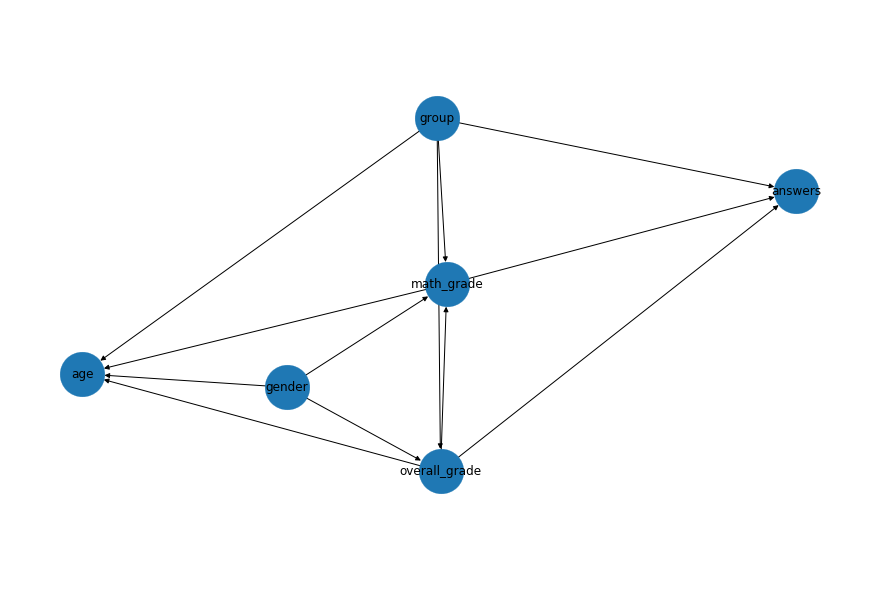

In [1085]:
np.random.seed(9)
plt.figure(figsize=(12, 8))
labels_list = dag.columns.tolist()
labels = dict(zip(range(len(labels_list)), labels_list))
show_graph_with_labels(dag.values, labels)

In [973]:
dag = dag.drop("age", axis=1)
dag = dag.drop(3, axis=0)

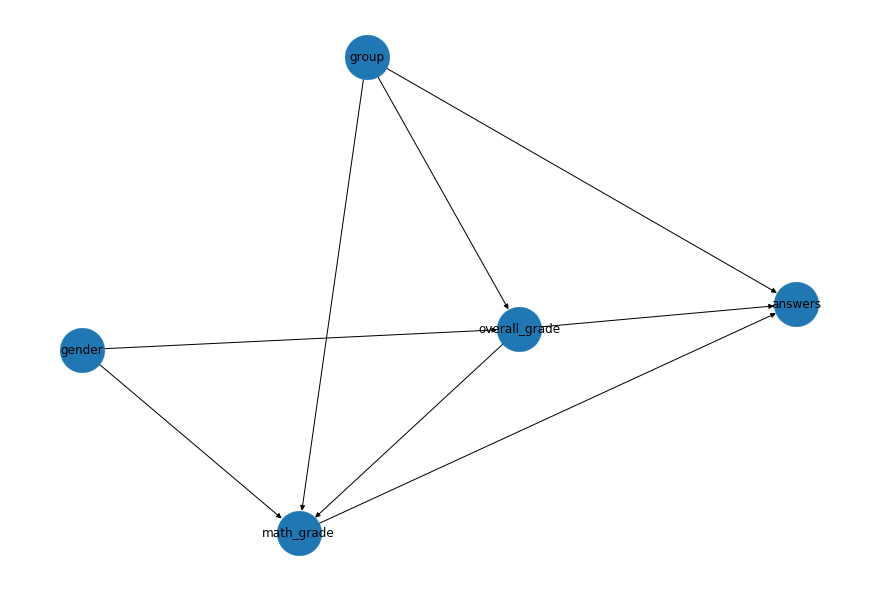

In [974]:
np.random.seed(9)
plt.figure(figsize=(12, 8))
labels_list = dag.columns.tolist()
labels = dict(zip(range(len(labels_list)), labels_list))
show_graph_with_labels(dag.values, labels)

### Non-linear

In [975]:
data_path = Path("./data/")
dag_nonlinear = pd.read_csv(data_path /  "dag_nonlinear.csv", names=['group', 'answers', 'gender', 'age', 'math_grade', 'overall_grade'])

In [976]:
dag_nonlinear

,group,answers,gender,age,math_grade,overall_grade
0,0.0,6.853067,0.0,1.561100,0.321146,0.0
1,0.0,0.000000,0.0,0.955253,0.000000,0.0
2,0.0,1.467087,0.0,1.387362,0.000000,0.0
3,0.0,0.000000,0.0,0.000000,0.000000,0.0
4,0.0,1.645148,0.0,2.357804,0.000000,0.0
5,0.0,2.602485,0.0,1.192602,1.623877,0.0


In [977]:
dag_nonlinear[dag_nonlinear != 0] = 1
dag_nonlinear.head(10)

,group,answers,gender,age,math_grade,overall_grade
0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0
5,0.0,1.0,0.0,1.0,1.0,0.0


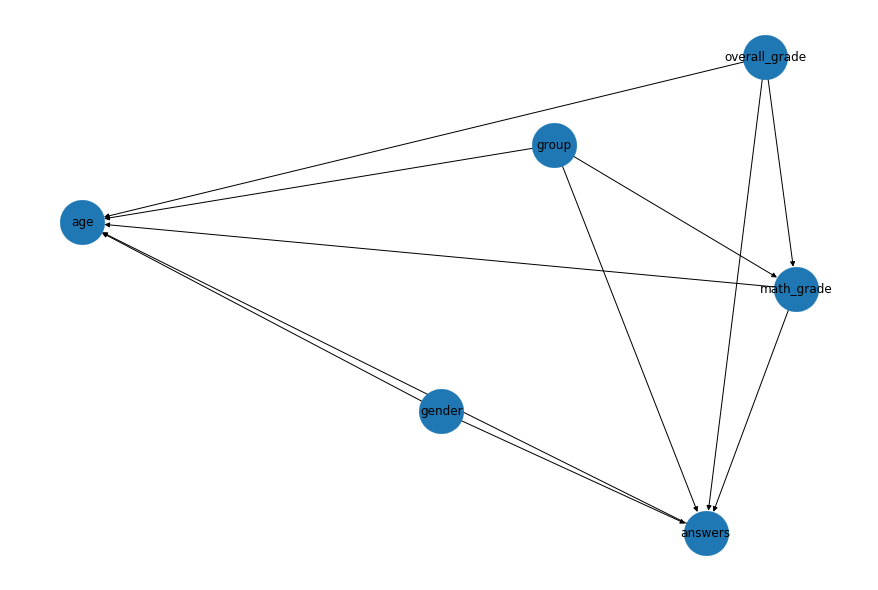

In [978]:
np.random.seed(9)
plt.figure(figsize=(12, 8))
labels_list = dag_nonlinear.columns.tolist()
labels = dict(zip(range(len(labels_list)), labels_list))
show_graph_with_labels(dag_nonlinear.values, labels)

In [979]:
dag_nonlinear = dag_nonlinear.drop("age", axis=1)
dag_nonlinear = dag_nonlinear.drop(3, axis=0)

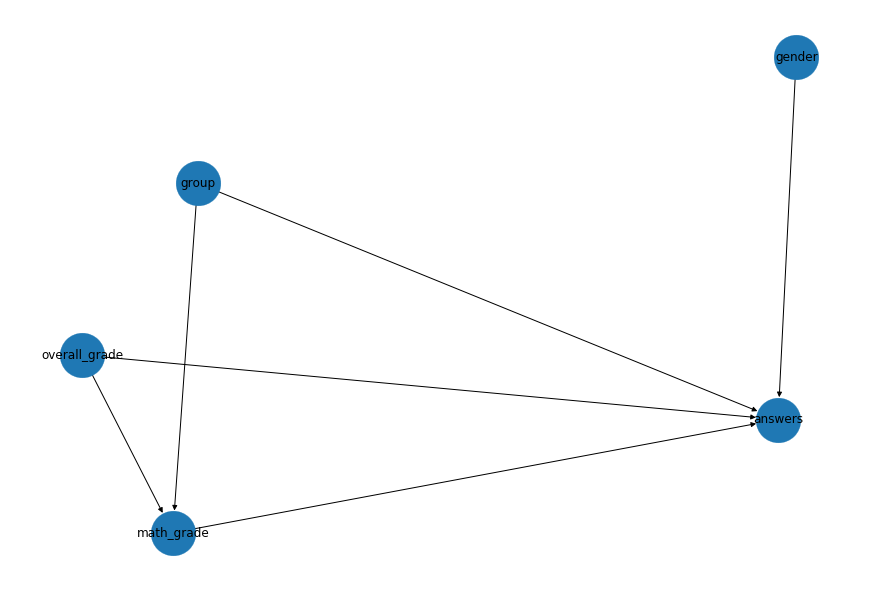

In [1054]:
np.random.seed(9)
plt.figure(figsize=(12, 8))
labels_list = dag_nonlinear.columns.tolist()
labels = dict(zip(range(len(labels_list)), labels_list))
show_graph_with_labels(dag_nonlinear.values, labels)

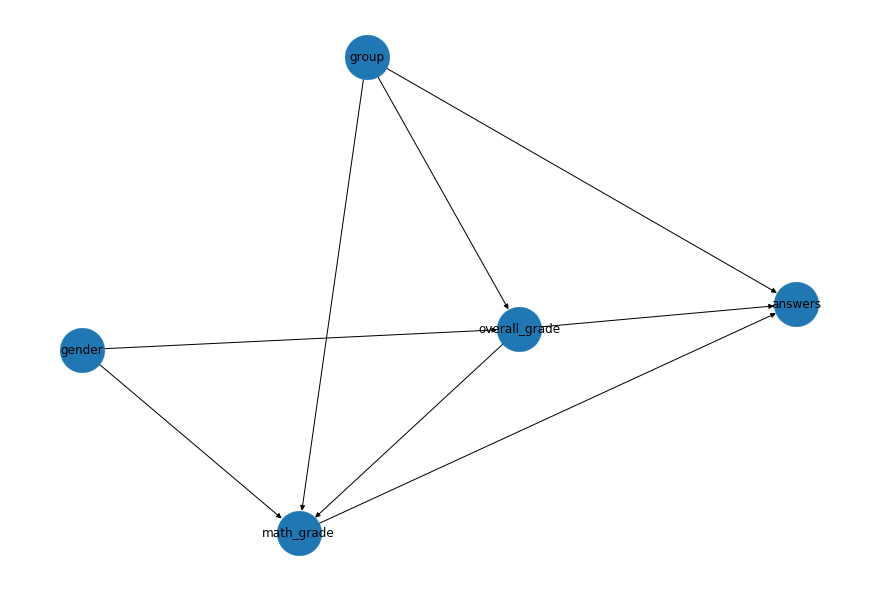

In [981]:
np.random.seed(9)
plt.figure(figsize=(12, 8))
labels_list = dag.columns.tolist()
labels = dict(zip(range(len(labels_list)), labels_list))
show_graph_with_labels(dag.values, labels)

## Checking the assumptions

### gender

In [982]:
import scipy.stats as stats

In [983]:
def two_proprotions_test(success_a, size_a, success_b, size_b):
    """
    A/B test for two proportions;
    given a success a trial size of group A and B compute
    its zscore and pvalue
    
    Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group
        
    size_a, size_b : int
        Size, or number of observations in each group
    
    Returns
    -------
    zscore : float
        test statistic for the two proportion z-test

    pvalue : float
        p-value for the two proportion z-test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    prop_pooled = (success_a + success_b) / (size_a + size_b)
    var = prop_pooled * (1 - prop_pooled) * (1 / size_a + 1 / size_b)
    zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2
    return {
        "z-score": zscore,
        "p-value": pvalue
    }


In [985]:
gender_check = data_processed[['group', 'gender']]

In [986]:
group_a = gender_check[gender_check.group == 0]
group_b = gender_check[gender_check.group == 1]
two_proprotions_test(group_a.gender.sum(), group_a.shape[0],  group_b.gender.sum(), group_b.shape[0]) 

{'z-score': 0.17509322426058543, 'p-value': 0.8610063822855212}

### Math Grade

In [987]:
import pymc3 as pm

In [988]:
grade_check = data_processed[['gender', 'math_grade']]

In [989]:
group_a = grade_check[grade_check.gender == 0]
group_b = grade_check[grade_check.gender == 1]

In [990]:
mu_m = grade_check.math_grade.values.mean()
mu_s = grade_check.math_grade.values.std() * 2

sigma_low = 1
sigma_high = 100

with pm.Model() as model:
    group_a_mean = pm.Normal('group1_mean', mu=mu_m, sd=mu_s)
    group_b_mean = pm.Normal('group2_mean', mu=mu_m, sd=mu_s)
    
    group_a_std = pm.Uniform('group1_std', lower=sigma_low, upper=sigma_high)
    group_b_std = pm.Uniform('group2_std', lower=sigma_low, upper=sigma_high)
    
    nu = pm.Exponential('ν_minus_one', 1/29.) + 1
    
    lambda_a = group_a_std**-2
    lambda_b = group_b_std**-2

    group_a_dist = pm.StudentT('drug', nu=nu, mu=group_a_mean, lam=lambda_a, observed=group_a.math_grade.values)
    group_b_dist = pm.StudentT('placebo', nu=nu, mu=group_b_mean, lam=lambda_b, observed=group_b.math_grade.values)
    
    
    diff_of_means = pm.Deterministic('difference of means', group_a_mean - group_b_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group_a_std - group_b_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group_a_std**2 + group_b_std**2) / 2))
    
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]
INFO:pymc3:NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:05<00:00, 3769.10draws/s]


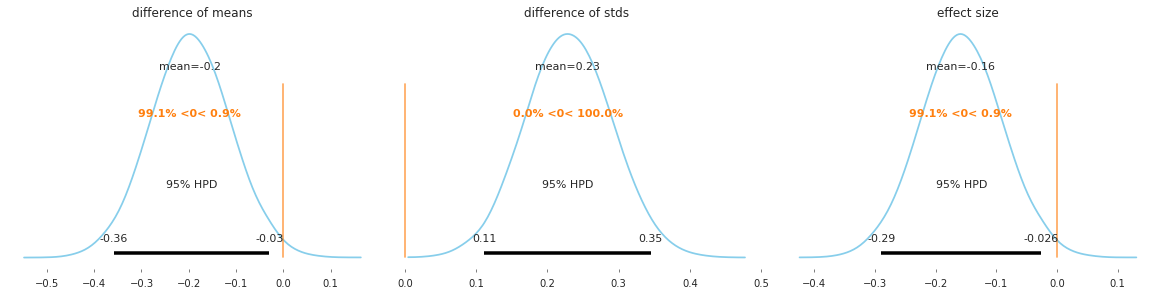

In [991]:
pm.plot_posterior(trace, var_names=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  credible_interval=0.95,
                  color='#87ceeb',
                  figsize=(16, 4));

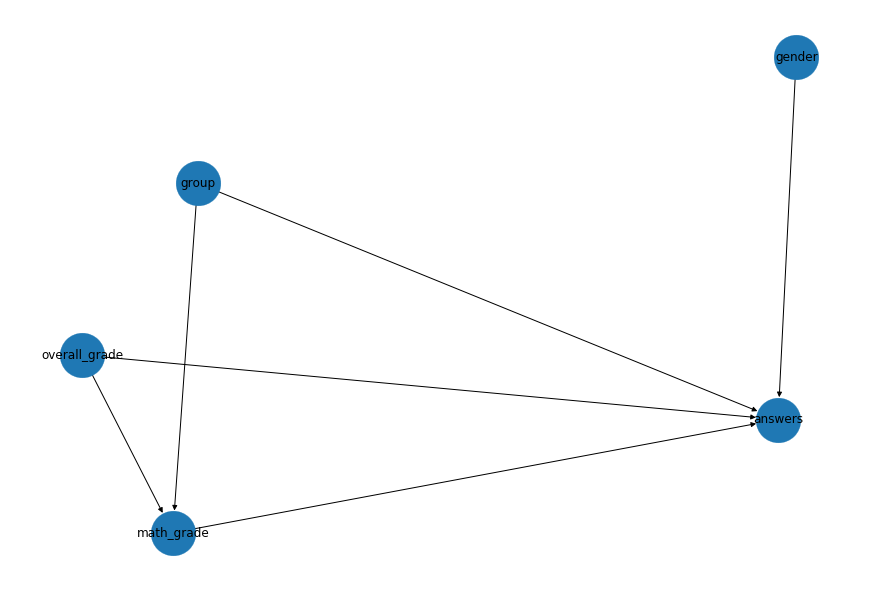

In [1099]:
np.random.seed(9)
plt.figure(figsize=(12, 8))
labels_list = dag_nonlinear.columns.tolist()
labels = dict(zip(range(len(labels_list)), labels_list))
show_graph_with_labels(dag_nonlinear.values, labels)

## Running the model

In [1100]:
import dowhy
from dowhy import CausalModel
import dowhy.datasets

In [1101]:
data_processed.head()

,id,group,answers,gender,age,math_grade,overall_grade,propensity_scores
0,3.0,0.0,14.0,1.0,24.0,6.0,0.0,0.258081
1,4.0,0.0,7.0,1.0,19.0,6.5,0.0,0.311802
2,5.0,0.0,9.0,1.0,23.0,7.0,0.0,0.313993
3,6.0,0.0,11.0,1.0,17.0,6.7,0.0,0.334922
4,7.0,0.0,11.0,0.0,21.0,6.8,0.0,0.322943


In [1102]:
data_processed_new  = data_processed.copy()
data_processed_new.group = data_processed_new.group.astype('bool')
model=CausalModel(
        data = data_processed_new,
        treatment="group",
        outcome="answers",
        graph="data/last_dag.gml"
        )

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['group'] on outcome ['answers']


In [1103]:
model.view_model();

In [1104]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [1113]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: answers~group+group*overall_grade+group*math_grade+group*gender


In [1114]:
print(estimate)

*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                          
────────(Expectation(answers))
d[group]                      
Estimand assumption 1, Unconfoundedness: If U→{group} and U→answers then P(answers|group,,U) = P(answers|group,)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: answers~group+group*overall_grade+group*math_grade+group*gender
## Estimate
Value: 7.15406872639184



In [1131]:
data_model = data_processed.copy()
data_model['gr_math'] = data_model['group']*data_model['math_grade']
data_model['gr_gender'] = data_model['group']*data_model['gender']
data_model['gr_overall'] = data_model['group']*data_model['overall_grade']
data_model['gr_age'] = data_model['group']*data_model['age']
data_model['gr_mix'] = data_model['group']*data_model['overall_grade']*data_model['math_grade']

In [1132]:
y, X = dmatrices('answers ~  group + gr_math + gr_overall + gr_gender', data=data_model, return_type='dataframe')
mod = sm.OLS(y, X, hasconst=False) 
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                answers   R-squared (uncentered):                   0.918
Model:                            OLS   Adj. R-squared (uncentered):              0.917
Method:                 Least Squares   F-statistic:                              2048.
Date:                Wed, 29 Apr 2020   Prob (F-statistic):                        0.00
Time:                        11:33:57   Log-Likelihood:                         -2863.4
No. Observations:                 921   AIC:                                      5737.
Df Residuals:                     916   BIC:                                      5761.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.8321      0.231     51.244      0.000      11.379      12.285
group          7.1541      1.847      3.874      0.000       3.530      10.778
gr_math        0.3742      0.281      1.331      0.183      -0.177       0.926
gr_overall     2.0139      0.564      3.569      0.000       0.907       3.121
gr_gender      0.0201      0.585      0.034      0.973      -1.128       1.168
==============================================================================
Omnibus:                      147.840   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              316.673
Skew:                          -0.908   Prob(JB):                     1.72e-69
Kurtosis:                       5.225   Cond. No.                         54.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Propensity score matching

In [1118]:
from sklearn.linear_model import LogisticRegression
import numpy as np

In [1119]:
X, y = data_model[['gender', 'math_grade', 'overall_grade', 'age']].values, data_processed['group'].values

In [1120]:
indices = np.arange(0, X.shape[0])
np.random.shuffle(indices)

In [1121]:
clf = LogisticRegression(random_state=0).fit(X[indices, :], y[indices])
propensity_scores = clf.predict_proba(X)[:, 1]

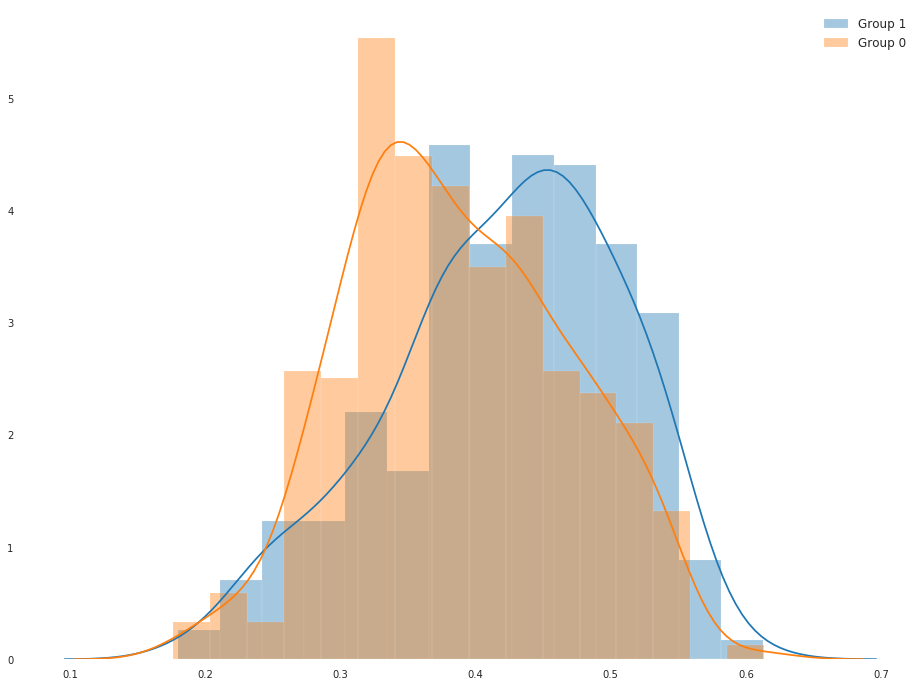

In [1122]:
plt.figure(figsize=(16, 12))
label1_ix = np.where(y == 1)[0]
label0_ix = np.where(y== 0)[0]
sns.distplot(propensity_scores[label1_ix], label='Group 1')
sns.distplot(propensity_scores[label0_ix], label='Group 0')
plt.legend(prop={'size': 12});

In [1123]:
# propensity_scores = np.hstack((propensity_scores, propensity_scores))
# propensity_scores

In [1124]:
data_model.shape, propensity_scores.shape

In [1125]:
data_model['propensity_scores'] = propensity_scores

In [1126]:
group_1 = data_model[(data_processed.group==1)]
group_0 = data_model[(data_processed.group==0)]
data_matched_status = group_1.copy()
prop_scores = group_0.propensity_scores.values
for index, row in group_1.iterrows():
    index = np.argmin(np.abs(prop_scores-row['propensity_scores']))
    data_matched_status = data_matched_status.append(group_0.iloc[index, :])
    

In [1127]:
data_matched = data_matched_status.copy()#pd.concat([data_matched_status0, data_matched_status1])

In [1128]:
data_matched.shape

In [1130]:
y, X = dmatrices('answers ~ group', data=data_matched, return_type='dataframe')
mod = sm.OLS(y, X, hasconst=False) 
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                answers   R-squared (uncentered):                   0.917
Model:                            OLS   Adj. R-squared (uncentered):              0.916
Method:                 Least Squares   F-statistic:                              4021.
Date:                Wed, 29 Apr 2020   Prob (F-statistic):                        0.00
Time:                        11:31:39   Log-Likelihood:                         -2337.0
No. Observations:                 734   AIC:                                      4678.
Df Residuals:                     732   BIC:                                      4687.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.8311      0.305     38.748      0.000      11.232      12.431
group         12.8610      0.432     29.784      0.000      12.013      13.709
==============================================================================
Omnibus:                      117.351   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              230.588
Skew:                          -0.926   Prob(JB):                     8.48e-51
Kurtosis:                       5.027   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""